# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

import datetime

from typing import Union

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

import catboost
import xgboost
import lightgbm

In [2]:
import sklearn
from sklearn import set_config

In [3]:
if sklearn.__version__ not in ["1.2.0", "1.2.2", "1.4.1.post1"]:
    os.system("pip install scikit-learn==1.2.0")

# Global Configuration

In [4]:
set_config(transform_output="pandas")

In [5]:
CWD = os.getcwd()
KAGGLE = "kaggle" in CWD

In [6]:
print(CWD)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml


In [7]:
if not KAGGLE:
    PATH_INPUT = os.path.join(CWD, "input")
    PATH_INPUT_TRAIN = os.path.join(PATH_INPUT, "train.csv")
    PATH_INPUT_TEST = os.path.join(PATH_INPUT, "test.csv")
    
    print(os.listdir(PATH_INPUT))
    
else:
    PATH_INPUT_TRAIN = "/kaggle/input/spaceship-titanic/train.csv"
    PATH_INPUT_TEST = "/kaggle/input/spaceship-titanic/test.csv"

['test.csv', 'spaceship-titanic.zip', 'train.csv', 'sample_submission.csv']


In [8]:
sorted(os.listdir(CWD))

['.DS_Store',
 '.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'EDA.ipynb',
 'MODEL.ipynb',
 'MODEL_KAGGLE.ipynb',
 'catboost_info',
 'input',
 'notebooks',
 'outputs',
 'requirements.txt',
 'src',
 'venvs',
 'videos']

# Helper functions and classes

In [9]:
def drop_duplicated_columns(X):
    return X.iloc[:, ~X.columns.duplicated()]

def get_pipe_without_model():
    
    pipe = Pipeline(
        steps = [
            ("impute", ct_impute),
            ("fe", ct_fe),
            ("drop_duplicated_columns", FunctionTransformer(drop_duplicated_columns)),
        ]
    )
    
    return pipe

def get_pipe(model = None):
    
    if model is None:
        return get_pipe_without_model()
    
    else:
        
        pipe = Pipeline(
            steps = [
                ("impute", ct_impute),
                ("fe", ct_fe),
                ("drop_duplicated_columns", FunctionTransformer(drop_duplicated_columns)),
                ("model", model)
            ]
        )
    
        return pipe

def get_fi(model):
    
    if isinstance(model, catboost.CatBoostClassifier):
        return model.get_feature_importance()
    
    elif isinstance(model, xgboost.XGBClassifier):
        return model.feature_importances_
    
    elif isinstance(model, lightgbm.LGBMClassifier):
        return model.feature_importances_

def create_fi_df(model, X):
    
    fi = get_fi(model = model)
    fn = X.columns
    
    fidf = pd.DataFrame(
        data  = [
            fn,
            fi
        ]
    ).T
    
    fidf.rename(
        columns = {
            0:"FeatureName",
            1:"FeatureImportance"
        },
        inplace = True
    )
    
    return fidf.sort_values("FeatureImportance", ascending = False)

def run_experiment(model, X_train, y):
    
    pipe = get_pipe(model = model)
    
    cv_scores = cross_val_score(
        estimator = pipe,
        X = X_train,
        y = y,
        cv = 10,
        n_jobs = -1,
        scoring = "accuracy"
    )
    
    print(str(model))
    print(cv_scores)
    print(f"Mean: {np.mean(cv_scores)}")
    print(f"Std: {np.std(cv_scores)}")
    
    Xt = pipe[:-1].fit_transform(X_train)
    pipe.fit(X_train, y)
    model_fitted = pipe[-1]
    
    try:
        fidf = create_fi_df(model = model_fitted, X = Xt)
    except:
        fidf = None
    
    return pipe, cv_scores, Xt, model_fitted, fidf

In [10]:
class DebuggerTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print("DummyTransformer")
        return X



class CabinLetterExtractor(BaseEstimator, TransformerMixin):


    def __init__(self, letter:Union["first", "last"], verbose:bool=False):

        self.__assert_letter(letter=letter)

        self.letter = letter
        self.verbose = verbose

    def __assert_letter(self, letter):

        assert_message = "Valid letters are `first` or `last`."
        assert_message += f"You have passed {letter}"

        assert letter in ["first", "last"], assert_message

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        if self.verbose:
            print("CabinLetterExtractor")
            print(type(X))

        if self.letter == "first":
            return X.iloc[:, 0].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin).to_frame()
        else:
            return X.iloc[:, 0].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin).to_frame()



class SurnameExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, verbose:bool=False):
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.iloc[:, 0].apply(lambda name: name.split(" ")[1] if name != "NA" else name).to_frame()

    
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, list_surnames):
        self.list_surnames = list_surnames
        self.oe = OrdinalEncoder()
        
        
    def fit(self, X, y=None):
        
        self.oe.fit(self.list_surnames)
        
        return self
    
    def transform(self, X, y=None):
        Xt = self.oe.transform(X)
        return Xt
    
    
def report_cv_scores(cv_scores):
    
    if isinstance(cv_scores[0], tuple):
        
        for model_name, cv_scores_ in cv_scores:
            
            mean_cv_scores = np.mean(cv_scores_)
            std_cv_scores = np.std(cv_scores_)
            
            print(f"Model used {model_name}")
            print(f"Mean scores: {mean_cv_scores}")
            print(f"Std scores: {std_cv_scores}")
            print(f"Scores: {cv_scores_}")
            print("-"*50)
        
    else:
        mean_cv_scores = np.mean(cv_scores)
        std_cv_scores = np.std(cv_scores)

        print(f"Mean scores: {mean_cv_scores}")
        print(f"Std scores: {std_cv_scores}")
        print(f"Scores: {cv_scores}")
        
class MyCustomVotingClassifier():
    
    def __init__(self, estimators, voting='hard'):
        self.estimators = estimators
        self.voting = voting
        
    def fit(self, X, y):
        
        for _, estimator in self.estimators:
            estimator.fit(X, y)
            
        return self
    
    
    def _predict(self, X):
        
        estimators_name = []
        estimators_predict = []
        
        for estimator_name, estimator in self.estimators:
            
            if self.voting == "hard":
                y_pred_ = estimator.predict(X) * 1
                
            else:
                y_pred_ = estimator.predict_proba(X)[:, 1]
            
            estimators_name.append(estimator_name)
            estimators_predict.append(y_pred_)
            
        return estimators_name, estimators_predict
    
    
    def _names_predictions_to_df(self, X, estimators_name, estimators_predict):
        
        df_scores = pd.DataFrame(
            data = estimators_predict
        ).T
        
        df_scores.columns = estimators_name
        df_scores.index = X.index
        
        return df_scores
        
    
    def predict(self, X):
        
        estimators_name, estimators_predict = self._predict(X=X)
            
        df_scores = self._names_predictions_to_df(
            X=X,
            estimators_name=estimators_name,
            estimators_predict=estimators_predict
        )
            
        return df_scores
    
class MiddleLetterExtractor(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X["impute_cabin__Cabin"].apply(
            lambda cabin: 2000 if cabin == "NA" else float(cabin.split("/")[1])
        ).to_frame()

In [11]:
def load_data():
    
    X_train = pd.read_csv(PATH_INPUT_TRAIN).set_index("PassengerId")
    X_test = pd.read_csv(PATH_INPUT_TEST).set_index("PassengerId")
    
    return X_train, X_test

# Data Loading

In [12]:
X_train, X_test = load_data()

In [13]:
y = X_train.pop("Transported")

# Impute data with Pipelines

In [14]:
ct_impute = ColumnTransformer(
    transformers = [
        
        (
            "impute_numerical",
            SimpleImputer(strategy="mean"),
            ['Age']
        ),
        
        (
            "impute_zero",
            SimpleImputer(strategy="constant", fill_value = 0),
            ['RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', "Spa"]
        ),
        
        ("impute_cabin", SimpleImputer(strategy="constant", fill_value="NA"), ["Cabin"]),
        
        (
            "impute_categorical",
            SimpleImputer(strategy="most_frequent"),
            ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name']
        )
    ],
    remainder = 'drop'
)

# Preprocess Data Post Imputation

In [15]:
pipe_spa = FeatureUnion(
    transformer_list = [
        ("spa_binarizer", Binarizer()),
        ("spa_discritizer_20", KBinsDiscretizer(n_bins = 20, strategy = "uniform", encode = "ordinal")),
        ("spa_discritizer_50", KBinsDiscretizer(n_bins = 20, strategy = "uniform", encode = "ordinal"))
    ]
    
)

In [16]:
pipe_mle = Pipeline(
    steps = [
        ("mle", MiddleLetterExtractor()),
        ("fu_mle", FeatureUnion(
            transformer_list = [
                ("kbins_20", KBinsDiscretizer(n_bins = 20, strategy = "uniform", encode = "ordinal")),
                ("kbins_50", KBinsDiscretizer(n_bins = 50, strategy = "uniform", encode = "ordinal")),
                ("kbins_100", KBinsDiscretizer(n_bins = 100, strategy = "uniform", encode = "ordinal"))
            ]
        ))   
    ]
)

In [17]:
fu_age = FeatureUnion(
    transformer_list = [
        ("fe_age_12", Binarizer(threshold=12)),
        ("fe_age_18", Binarizer(threshold=18)),
        ("fe_age_buckets", KBinsDiscretizer(encode = "ordinal", strategy = "uniform", n_bins = 8)),
        ("fe_age_pass", "passthrough")       
    ]
)

In [18]:
fu_cabin = FeatureUnion(
    transformer_list = [
        ("extract_first_letter", CabinLetterExtractor(letter="first")),
        ("extract_last_letter", CabinLetterExtractor(letter="last"))
    ]
)

In [19]:
fe_cabin = Pipeline(
    steps = [
        ("extract_letters_from_cabin", fu_cabin),
        ("ohe_first_letter", OneHotEncoder(sparse_output=False)),
    ]
)

In [20]:
# We are getting all the surnames that exist in train and test
# because our CustomOrdinalEncoder can faill when doing CV
# or when predicting test
surnames_ = pd.concat([X_train[["Name"]], X_test[["Name"]]]).dropna()

In [21]:
SURNAMES = SurnameExtractor().fit_transform(surnames_).values

In [22]:
fe_surname = Pipeline(
    steps = [
        ("extract_surname", SurnameExtractor()),
        ("custom_ordinal_encoder", CustomOrdinalEncoder(list_surnames=SURNAMES))
    ]
)

In [23]:
ct_impute.fit_transform(X_train).columns.tolist()

['impute_numerical__Age',
 'impute_zero__RoomService',
 'impute_zero__FoodCourt',
 'impute_zero__ShoppingMall',
 'impute_zero__VRDeck',
 'impute_zero__Spa',
 'impute_cabin__Cabin',
 'impute_categorical__HomePlanet',
 'impute_categorical__CryoSleep',
 'impute_categorical__Destination',
 'impute_categorical__VIP',
 'impute_categorical__Name']

In [24]:
Xt = ct_impute.fit_transform(X_train)

In [25]:
def concatenate_cryo_planet(df):
    Xt = (
        (df["impute_categorical__HomePlanet"] + "_" + df["impute_categorical__CryoSleep"].astype(str))
        .to_frame()
        .rename(
            columns = {
                0:"PlanetCryoSleep"
            }
        )
    )
    
    return Xt

In [26]:
pipe_cryo_planet = Pipeline(
    steps = [
        ("fe_cryo_planet", FunctionTransformer(func = concatenate_cryo_planet)),
        ("oe_cryo_planet", OrdinalEncoder())
    ]
)

In [27]:
fu_total_spent = FeatureUnion(
    transformer_list = [
        ("pass", "passthrough"),
        (
            "total_spent_cal",
            FunctionTransformer(
                func = lambda df: df.sum(axis = 1).to_frame().rename(columns = {0:"TotalSpent"})
            )
        )
    ]
)

In [28]:
ct_fe = ColumnTransformer(
    transformers = [
        ("fu_age", fu_age, ["impute_numerical__Age"]),
        ("fu_total_spent", fu_total_spent, [1, 2, 3, 4, 5]),
        ("fu_spa", pipe_spa, ["impute_zero__Spa"]),
        ("fe_cabin", fe_cabin, ["impute_cabin__Cabin"]),
        ("mle", pipe_mle, ["impute_cabin__Cabin"]),
#         (
#             "fe_cryo_planet",
#             pipe_cryo_planet,
#             ["impute_categorical__HomePlanet", "impute_categorical__CryoSleep"]
#         ),
        (
            "ohe",
            OneHotEncoder(sparse_output=False),
            ["impute_categorical__HomePlanet", "impute_categorical__CryoSleep", "impute_categorical__VIP"]
        ),
        ("oe", OrdinalEncoder(), ["impute_categorical__Destination"]),
        ("surname", fe_surname, ["impute_categorical__Name"])
    ],
    remainder = "passthrough"
)

In [29]:
model = catboost.CatBoostClassifier(verbose = 0)

In [30]:
pipe = get_pipe(model = model)

In [31]:
pipe

Pipeline(steps=[('impute',
                 ColumnTransformer(transformers=[('impute_numerical',
                                                  SimpleImputer(), ['Age']),
                                                 ('impute_zero',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['RoomService', 'FoodCourt',
                                                   'ShoppingMall', 'VRDeck',
                                                   'Spa']),
                                                 ('impute_cabin',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Cabin']),
                                                 ('impute_categorical',
                                                  SimpleImputer(strategy='m...
                                                                  ('custom_ordinal_encoder',
                                                                   CustomOrdinalEncoder(list_surnames=array([['Ofracculy'],
       ['Vines'],
       ['Susent'],
       ...,
       ['Pore'],
       ['Conale'],
       ['Leonzaley']], dtype=object)))]),
                                                  ['impute_categorical__Name'])])),
                ('drop_duplicated_columns',
                 FunctionTransformer(func=<function drop_duplicated_columns at 0x148b59750>)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x148d13910>)])

In [32]:
pipe[:-1].fit_transform(X_train).info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   fu_age__fe_age_12__impute_numerical__Age       8693 non-null   float64
 1   fu_age__fe_age_18__impute_numerical__Age       8693 non-null   float64
 2   fu_age__fe_age_buckets__impute_numerical__Age  8693 non-null   float64
 3   fu_age__fe_age_pass__impute_numerical__Age     8693 non-null   float64
 4   fu_total_spent__impute_zero__RoomService       8693 non-null   float64
 5   fu_total_spent__impute_zero__FoodCourt         8693 non-null   float64
 6   fu_total_spent__impute_zero__ShoppingMall      8693 non-null   float64
 7   fu_total_spent__impute_zero__VRDeck            8693 non-null   float64
 8   fu_total_spent__impute_zero__Spa               8693 non-null   float64
 9   fu_total_spent__TotalSpent                     8

In [33]:
pipe, cv_scores, Xt, model_fitted, fidf = run_experiment(
    model = model,
    X_train = X_train,
    y = y
)

print(f"Mean Score: {np.mean(cv_scores)}")
print(f"Std Score: {np.std(cv_scores)}")

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 wi

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OrdinalEncoder was fitted without feature names
  warnings.warn(
/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml/venvs/env_skrub/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample ex

[0.78045977 0.75747126 0.75287356 0.73187572 0.75604143 0.83544304
 0.84119678 0.83429229 0.81818182 0.76524741]
Mean: 0.7873083078713808
Std: 0.03878345503000579
Mean Score: 0.7873083078713808
Std Score: 0.03878345503000579


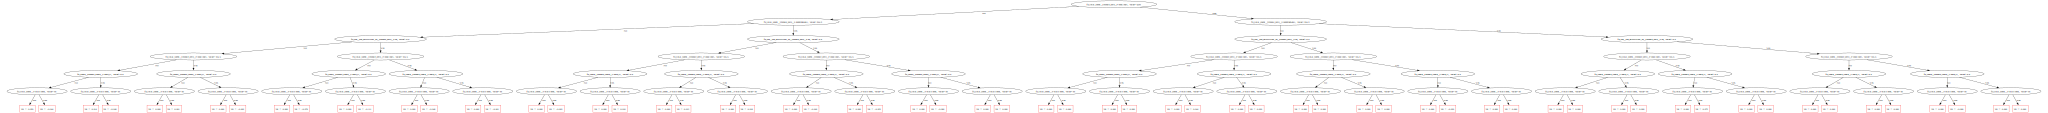

In [34]:
model_fitted.plot_tree(tree_idx = 1, pool = Xt)

In [35]:
fidf

,FeatureName,FeatureImportance
9,fu_total_spent__TotalSpent,12.071166
7,fu_total_spent__impute_zero__VRDeck,8.393284
5,fu_total_spent__impute_zero__FoodCourt,7.075397
8,fu_total_spent__impute_zero__Spa,5.925888
27,ohe__impute_categorical__HomePlanet_Earth,5.316898
4,fu_total_spent__impute_zero__RoomService,5.106572
26,mle__kbins_100__impute_cabin__Cabin,4.762435
3,fu_age__fe_age_pass__impute_numerical__Age,4.553542
35,surname__x0,4.094561
6,fu_total_spent__impute_zero__ShoppingMall,3.734323


# Submission a Kaggle

In [36]:
y_pred = pipe.predict(X_test)

In [37]:
timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
timestamp

'2024_04_27_20_26_20'

In [38]:
X_test_copy = X_test.copy(deep = True)

In [39]:
X_test_copy["Transported"] = list(map(bool, y_pred))

In [40]:
if not KAGGLE:
    path_export = os.path.join(CWD, "outputs", f"submission_{timestamp}.csv")
else:
    path_export = f"submission_{timestamp}.csv"

In [41]:
(
    X_test_copy
    .reset_index()
    [["PassengerId", "Transported"]]
    .to_csv(path_export, index=False)
)

In [45]:
# Benchmark -                        0.7234581961033293
# New Model con OHE -                0.7155214740155814
# New Model con 4 depth -            0.764529582159438
# Model with 4 depth y CabinFe -     0.7709713900242054
# HistGradient default params y -    0.7998441860772721
# HistGradient default params y -    0.8028344113328835  # Leaderboard - 1359
# default pipe + OE de Destionation

# HistGradient default params y -    0.8036411253521687  # Leaderboard - 1359 - 0.79331
# default pipe + OE de Destionation
# First and Last letter de Cabin

# HistGradient default params y -    0.8043334259222517 # Leaderboard -  1093 - 0.79682
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

# CatBoost default params y -        0.799844450617039 # Leaderboard -  985 - 0.79822
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder

# CatBoost default params y -        0.8023753025673586 # Leaderboard -  965 - 0.79869
# default pipe + OE de Destionation
# First and Last letter de Cabin
# Surname CustomOrdinalEncoder
# KBinsDiscretizer + Age

# Pipe with VotingClassifier        0.800306601589884   # Leaderboard - 966 - 0.79518
# 4 models: cat, xgb, hgb, rf

# Pipe with Catboost                
# 20, 50, 100 KBinsDiscretizar Cabin 0.7833970874171661 # Leaderboard - 744 - 0.80149

# Pipe with VotingClassfier (cat, xgb, rf, hgb)               
# 20, 50, 100 KBinsDiscretizar Cabin 0.7830545084189782 # Leaderboard - 672 - 0.80243

# Pipe with LGB
# 20, 50, 100 KBinsDiscretizar Cabin 0.7882285094506832 # Leaderboard - X - 0.79985

# Pipe with Cat
# 20, 50, 100 KBinsDiscretizar Cabin 0.7832833353173816 # Leaderboard - 359 - 0.80640
# Added ("fu_spa", pipe_spa, ["impute_spa__Spa"]),

# Pipe with Cat
# 20, 50, 100 KBinsDiscretizar Cabin 0.7873083078713808 # Leaderboard - 289 - 0.80757
# Added total spent as a new feature.

# The End